In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import make_blobs
X,Y = make_blobs(n_samples = 1000, n_features=2, centers=3)

### Applying Preprocessing to the data to make it zero mean, unit variance

In [4]:
df = pd.DataFrame({'X':X[:,0], 'Y':X[:,1]})

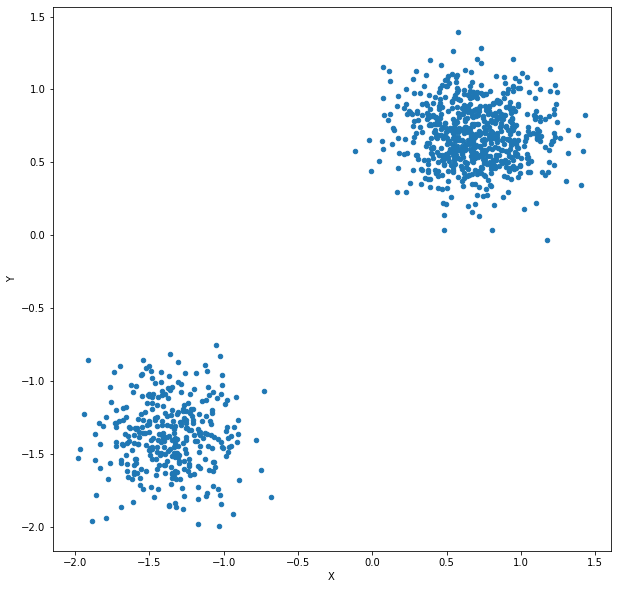

In [5]:
from sklearn.preprocessing import StandardScaler

df = df.dropna()

cols = list(df.columns)

for column in cols:
    df[column] = StandardScaler().fit_transform(df[[column]])

df.plot.scatter(x=cols[0], y=cols[1], figsize=(10,10))

 ### 2. Calculate the LOF score for each point  
      Assuming points having an LOF score greater than 1.5 to be outliers and mapping them in orange color

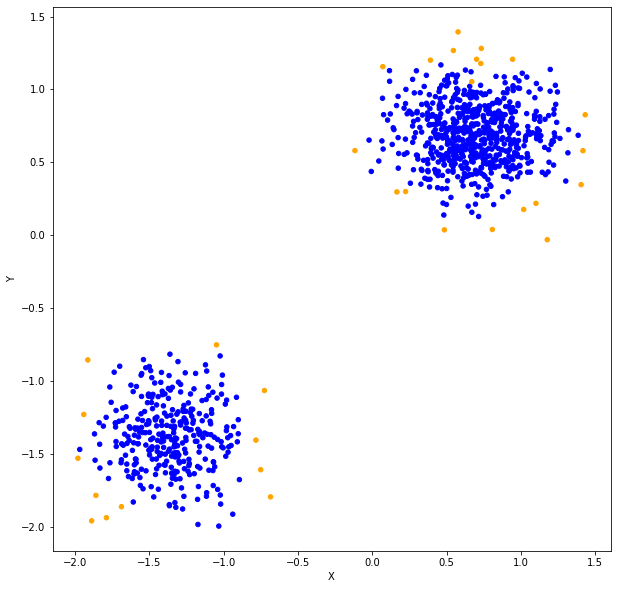

In [6]:
from sklearn.neighbors import LocalOutlierFactor

loc = LocalOutlierFactor(n_neighbors=10)
loc.fit(df)

df['LOF Score'] = loc.negative_outlier_factor_*(-1)
df['Outlier'] = loc.fit_predict(df)

df['color'] = df['LOF Score'].map(lambda x: 'orange' if x>=1.5 else 'blue')
ax1 = df.plot.scatter(x=cols[0], y=cols[1], c=df['color'],figsize=(10,10))

In [7]:
!jt -t monokai -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T

/bin/bash: jt: command not found


In [8]:
from sklearn.cluster import KMeans

clusterer = KMeans(3)
clusterer.fit(df[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

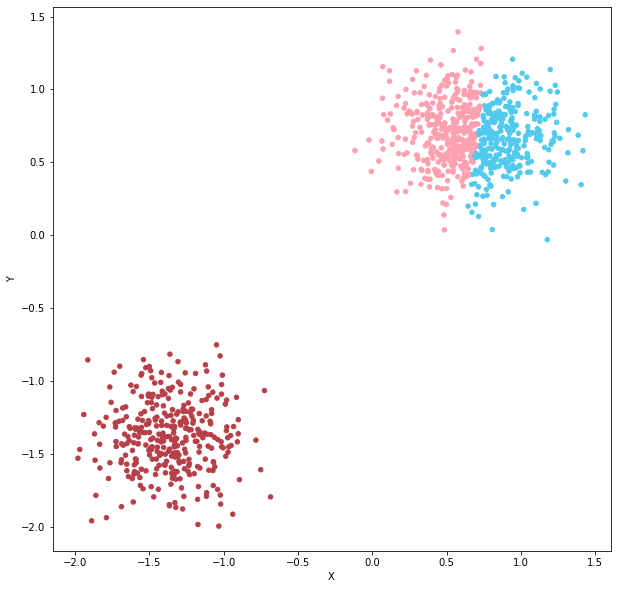

In [9]:
df['cluster'] = clusterer.predict(df[cols])
clus_names = df['cluster'].unique()

clus_colors = [tuple(np.random.choice(256, size=3)/255) for clus in clus_names]
clus_mapping = dict(zip(clus_names, clus_colors))

df['clus_color'] = df['cluster'].map(lambda x: clus_mapping[x])
ax1 = df.plot.scatter(x=cols[0], y=cols[1], c=df['clus_color'],figsize=(10,10))

### Function to separate clusters

In [10]:
from sklearn.cluster import OPTICS
import sklearn.metrics as sk

In [11]:
!git clone https://github.com/mennthor/awkde
!pip install -e ./awkde

Cloning into 'awkde'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 99
Receiving objects: 100% (102/102), 216.45 KiB | 6.76 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Obtaining file:///content/awkde
     |████████████████████████████████| 194kB 5.2MB/s 
  Running setup.py develop for awkde


In [46]:
!python /content/awkde/example/trial.py


0     -1333.649394
1     -1333.649394
2     -1333.649394
3     -1333.649394
4     -1333.649394
          ...     
995   -1333.649394
996   -1333.649394
997   -1333.649394
998   -1333.649394
999   -1333.649394
Name: akde, Length: 1000, dtype: float64


In [ ]:
df.cluster_label.unique()

array([56, 20, 44,  9, 36, 10, 39,  2, 28,  7, 43, 13, 12, 42, 29,  1, 46,
       38, 52, 45, 40, 11, 50, 21, 53, 16, 22, 49,  3, 37, 14,  8, 55,  4,
        5, 47, 35, 31, 26, 23, 18,  0,  6, 15, 24, 27, 30, 48, 51, 33, 54,
       34, 19, 41, 17, 25, 32])

In [13]:
df = generic_clustering(df[cols])
for clus_label in df['cluster_label'].unique():
  separate_cluster(df,clus_label)

In [ ]:
sns.pairplot(df[cols],height = 3.5)

In [ ]:
get_grid(df)

In [29]:
def generic_clustering(df):
    '''
    apply some form of clustering that is generic and does not need 
    user parameter input to separate data into logical clusters
    
    make a column named 'cluster_label' and store cluster labels there.
    some algorithms also output a -1 for outliers. handle that somehow
    
    Refer sklearn's clustering algorithms and choose accordingly.
    '''
    clustering = OPTICS(min_samples=5).fit_predict(df)
    df['cluster_label'] = clustering
    df['cluster_label'].replace(to_replace = -1,value = (df.cluster_label.max()+1),inplace = True)
    return df

def separate_cluster(df, clus_name):
    '''
    1. Use pandas slicing to separate rows with cluster 'clus_name'
    2. Calculate the min max values of x and y for the cluster
    3. Calculate the grid size using the point pair distances logic
    '''
    clus_df = df[df['cluster_label'] == clus_name]
    # Set xmin, ymin, xmax, ymax
    xmin = clus_df.X.min()
    xmax = clus_df.X.max()
    ymin = clus_df.Y.min()
    ymax = clus_df.Y.max()
    return xmin, ymin, xmax, ymax, clus_df

def get_grid(df):
    '''
    Calculate pairwise distances using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
    
    separately for x and y axis. youll get a 2d array. flatten it and make a histogram from it then visualize the histogram
    
    Try to figure out how to cut a left end of the histogram after giving visualizations (for starting cut it off at 20%)
    
    Then using that as grid spacing, make a grid span and a meshgrid of values.
    
    Refer Experiment 1.1 -only local gradients of this repo for the meshgrid logic
    '''
    x = np.array(df[cols[0]])
    pair_x = sk.pairwise_distances(x.reshape(-1,1))

    y = np.array(df[cols[1]])
    pair_y = sk.pairwise_distances(y.reshape(-1,1))

    #fig, axs = plt.subplots(1,2, sharey=True, tight_layout=False)
    #axs[0].hist(pair_x,bins = 5)
    #axs[1].hist(pair_y,bins = 5)

    grid_x = np.percentile(pair_x,20) # Cutting off 20% of the left tail
    grid_y = np.percentile(pair_y,20)
    #print(grid_x)

    x, y = cols[0], cols[1]

    # Coordinate axis values
    x, y = get_grid_span(df[x].tolist(),grid_x),get_grid_span(df[y].tolist(),grid_y)

    # Constructing a grid using those axes 
    xx, yy = np.meshgrid(x, y)
    return xx


def get_grid_span(coordinate_list,grid):
    '''
    Get the span and the grid spacing for the coordinate
    '''
    sort = sorted(coordinate_list)
    #print(np.arange(sort[0], sort[-1], grid))
    return np.arange(sort[0], sort[-1], grid)

def get_kde_size(clus_df):
    '''
    We are supposed to fit a gaussian over the points to get KDE size
    Do some research and implement it here and then return the KDE size
    '''
    return kde_size

## Function to separate outliers

In [ ]:
def separate_outliers(df, push_inliers=False):
    '''
    Main function to separate outliers
    
    push_inliers is a flag which is self explanatory
    '''
    df = generic_clustering(df) 
    cluster_names = df['cluster'].unique()
    
    for clus in cluster_names:
        
        xmin, ymin, xmax, ymax, clus_df = separate_cluster(df, clus)
        grid_span = get_grid(clus_df)
        kde_size = get_kde_size(clus_df)
        
        # Train a KDE on the cluster 
        kde = KernelDensity(bandwidth=kde_size)
        
        '''
        Follow the rest of the logic for calculating density over the cluster
        from experiment 1.1 of this repo.
        
        Youll get a 2D array for densities
        take that array, calculate gradients, again a 2D array.
        '''
        
        # Train a LOF model - refer any past experiments
        
        '''
        1. Now for each point in the cluster, take the x and y coordinate, 
            map it to the nearest x and y coordinate of the grid
        2. Get the LOF score for that point
        3. Determine if it is an outlier according to subtraction factor threshold
        4. Now we have to move the point
        5. Calculate the cell in the grid that we created above to which this point belongs
        6. Take the gradient of this point, use it to move the point - ask for any doubts 
        7. if it is an inlier, and the flag is true, push it in the direction of the gradient
        8. If it is outlier, push in negative direction of gradient 
        '''
        
        
        